# Modeling Templates - Classification

<pre>
Goal: show how simple models work on synthetic data
</pre>

In [1]:
import sys, os
import pandas as pd
import numpy as np
import datetime as dt
import time, glob, re, pickle, itertools, math
import IPython
# --------------------------------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%config InlineBackend.figure_format = 'retina'

In [2]:
# import our utilities
from util_jupyter import *
from util_models import *

In [3]:
import sklearn
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# conda install -c conda-forge xgboost 
from xgboost.sklearn import XGBClassifier

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import metrics
from scipy.stats import ks_2samp  # two identify essential features

# run_step - step from which we want to start
run_step = 0
nb_time_start = time.time()

np.shape(x) = (440,)
np.shape(y) = (440,)


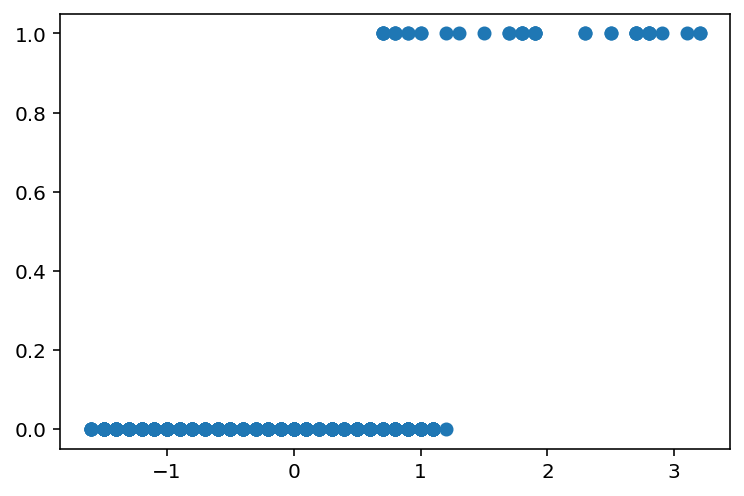

In [4]:
# create data as numpy arrays of shape (50,)
rng = np.random.RandomState(seed=1)  # container for random number generators
N = 40 # points
myrange = 10
myshift = 5
overlap = 3
myshift = myshift - int(overlap/2)
x1 = 10 * rng.rand(10*N) - myshift   # 20 random numbers in [-3,7] 
x2 = 10 * rng.rand(N) + myshift      # 20 random numbers in [3,13] 
x1 = x1.round(1) # 1 decimal digits is enough
x2 = x2.round(1) # 1 decimal digits is enough

y1 = np.array([0]*10*N)         # values 0
y2 = np.array([1]*N)            # values 1

x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((y1, y2), axis=0)

data = x[:, np.newaxis]                  # shape (80,1): [[v1],[v2],...]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data) # shape (80,1): [[v1],[v2],...]
x = data_scaled[:,0].round(1) # we don't need high precision
# print("x =", x)
# print("y =", y)
print("np.shape(x) =", np.shape(x)) # np.shape(x) = (80,)
print("np.shape(y) =", np.shape(y)) # np.shape(y) = (80,)

plt.rcParams["figure.figsize"] = (4, 4) # (width, height)
fig, ax = plt.subplots()
_ = ax.scatter(x,y);
plt.show();


## Logistic Regression - Linear Classification model

In [5]:
model = LogisticRegression(class_weight="balanced", solver='lbfgs', C=10)
model.fit(x[:, np.newaxis], y)

LogisticRegression(C=10, class_weight='balanced')

np.shape(model.coef_)      =  (1, 1)
np.shape(model.intercept_) =  (1,)
model.coef_      =  [[4.55090221]]
x =  [-3.70954078]


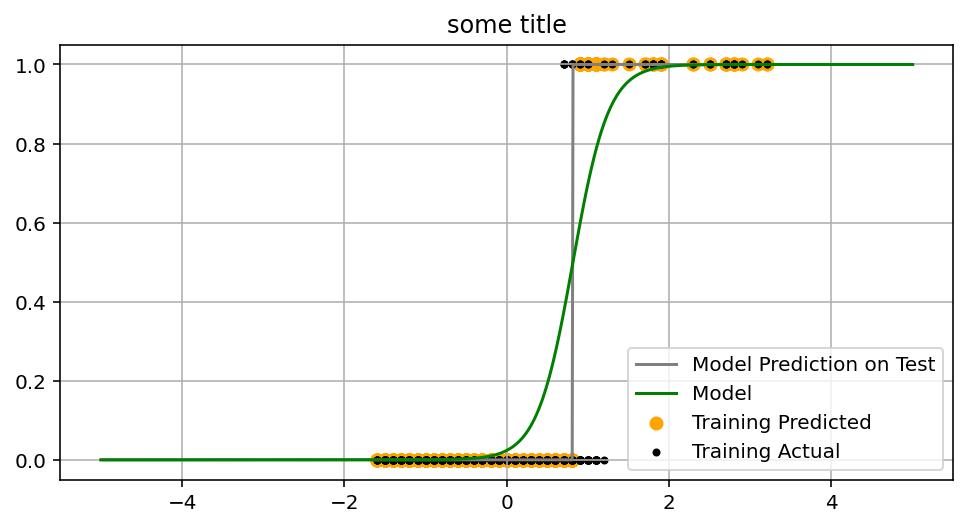

In [6]:
# create numpy array of shape (1000,)
xt = np.linspace(-5, 5, 1000)
# print(xt)
# print(type(xt))
yt = model.predict(xt[:, np.newaxis])  # (1000,) test
yp = model.predict(x[:, np.newaxis])   # (80,)   predicted on raining data

# sigmoidal curve of predicted probabiltiy on test data
ys = model.predict_proba(xt[:, np.newaxis])[:,1]  # (1000,)

# sigmoidal curve (ravel() removes unnecessary dimensions)
A = model.coef_.ravel()[0]
B = model.intercept_[0]
# ys = np.array([sigmoid(A*ii+B) for ii in xt])
# ys = sigmoid(xt * model.coef_ + model.intercept_).ravel() 
# ys = sigmoid(A*xt+B)

# print("np.shape(xt) = ",np.shape(xt))  # (1000,) test
# print("np.shape(yt) = ",np.shape(yt))  # (1000,) test
# print("np.shape(yp) = ",np.shape(yp))  # (80,)   training data
# print("np.shape(ys) = ",np.shape(ys))  # (1000,)
print("np.shape(model.coef_)      = ",np.shape(model.coef_))
print("np.shape(model.intercept_) = ",np.shape(model.intercept_))
print("model.coef_      = ", model.coef_)
print("x = ", model.intercept_)

plt.rcParams["figure.figsize"] = (8, 4) # (width, height)
fig, ax = plt.subplots()
_ = ax.plot(xt, yt, color='grey', label="Model Prediction on Test");  
_ = ax.plot(xt, ys, color='green', label="Model");
_ = ax.scatter(x, yp, color="orange", label="Training Predicted");
_ = ax.scatter(x, y, color ='black', marker='.', label="Training Actual");
_ = ax.legend(loc="lower right")
_ = ax.set_title('some title')
_ = ax.grid(True)
_ = plt.show();

## Confusion Matrix

[[351  49]
 [  7  33]]


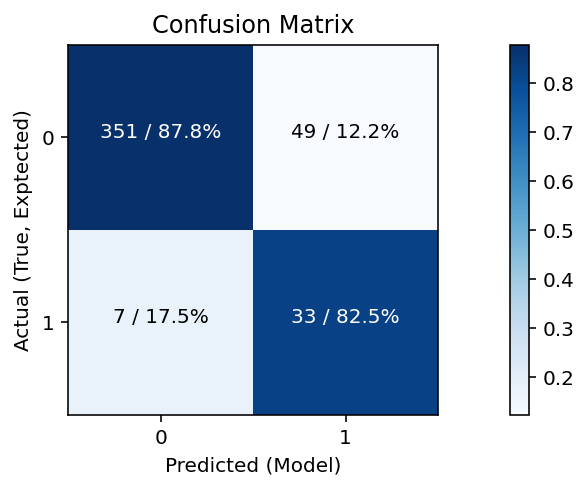

In [7]:
expected  = y 
predicted = yp
confusion = metrics.confusion_matrix(expected, predicted)
print(confusion)
plot_confusion_matrix(confusion)

In [8]:
def show_histogram(y):
    """ shows histogram of an array or a list (of numbers or strings, etc.)"""
    plt.rcParams["figure.figsize"] = (4, 4) # (width, height)
    plt.rcParams['font.size'] = 12
    fig, ax = plt.subplots()
    ax.hist(y, bins=100)
    ax.set_title('Histogram')
    fig.tight_layout()
    plt.show()

## Cat / Dog Example

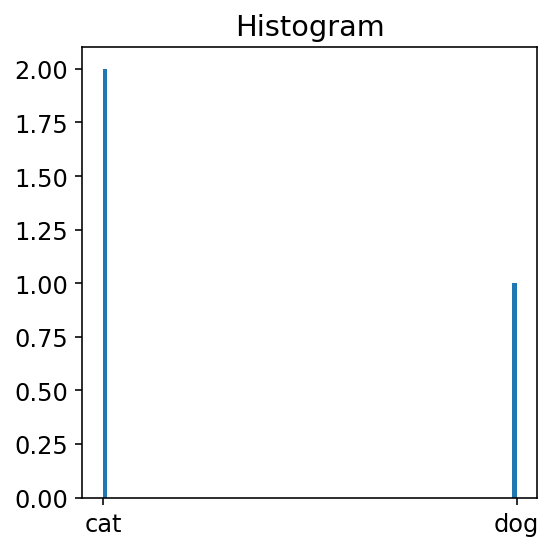

In [9]:
show_histogram(np.array(['cat','cat','dog']))

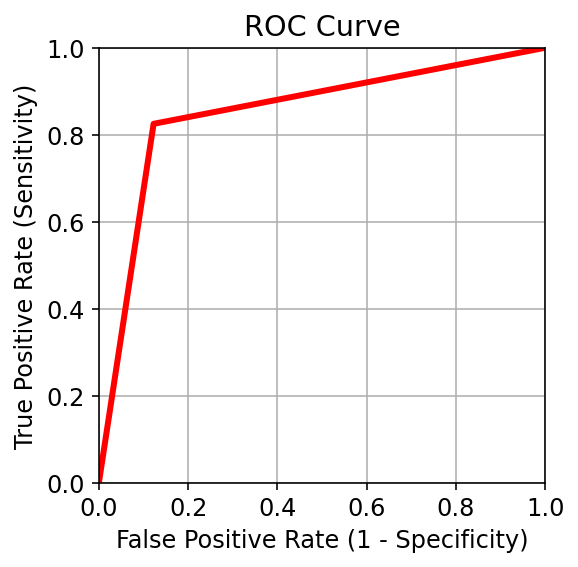

In [10]:
show_roc_curve(target=y, predict_proba=yp)

## Examples with two features x1 & x2 

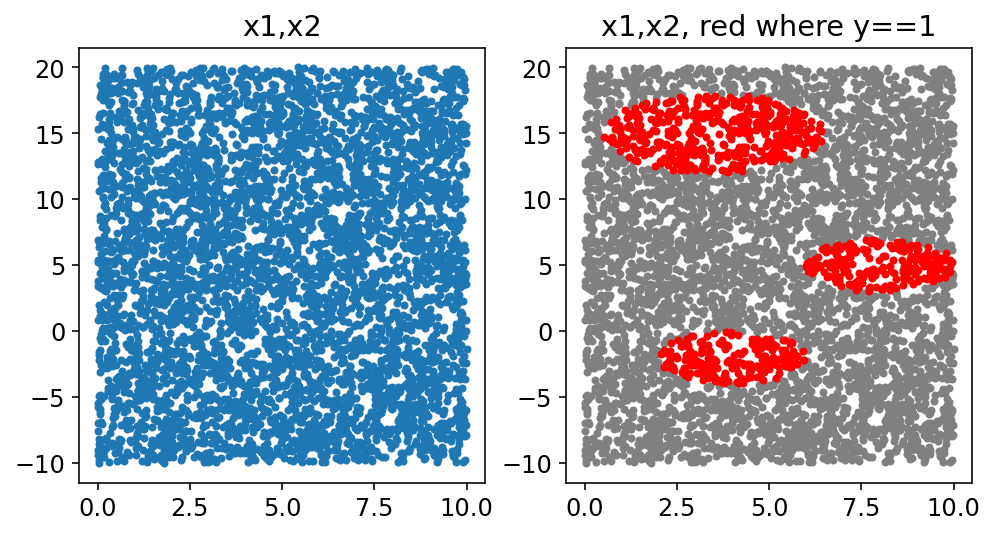

In [11]:
# Now let's do example of Logistic Regression with 2 features: x1, x2
N = 5000 # points
rng = np.random.RandomState(seed=1)
x1 = 10 * rng.rand(N)         # random numbers in [0,10] 
x2 = 30 * rng.rand(N) - 10    # random numbers in [-10,20] 
x1 = x1.round(3)
x2 = x2.round(3)
y  = np.zeros(N)
circles = [(3.5,15,3),(8,5,2), (4,-2,2)]

for ii in range(N):
    p1=x1[ii]
    p2=x2[ii]
    for c in circles:
        s1 = (c[0]-p1)**2
        s2 = (c[1]-p2)**2
        dist = math.sqrt(s1+s2)
        if dist < c[2]:
            y[ii] = True
            break

    # if (x1[ii] < 5) and (x2[ii] < 0):
    #     y[ii] = 1

plt.rcParams["figure.figsize"] = (8, 4) # (width, height)
fig,(ax1,ax2) = plt.subplots(1,2)
_ = ax1.scatter(x1,x2, marker='.')
_ = ax1.set_title("x1,x2")

indices = y == 1
_ = ax2.scatter(x1[~indices], x2[~indices], c = "grey", marker='.')
_ = ax2.scatter(x1[indices], x2[indices], c = 'red', marker='.')
_ = ax2.set_title("x1,x2, red where y==1")
plt.show()

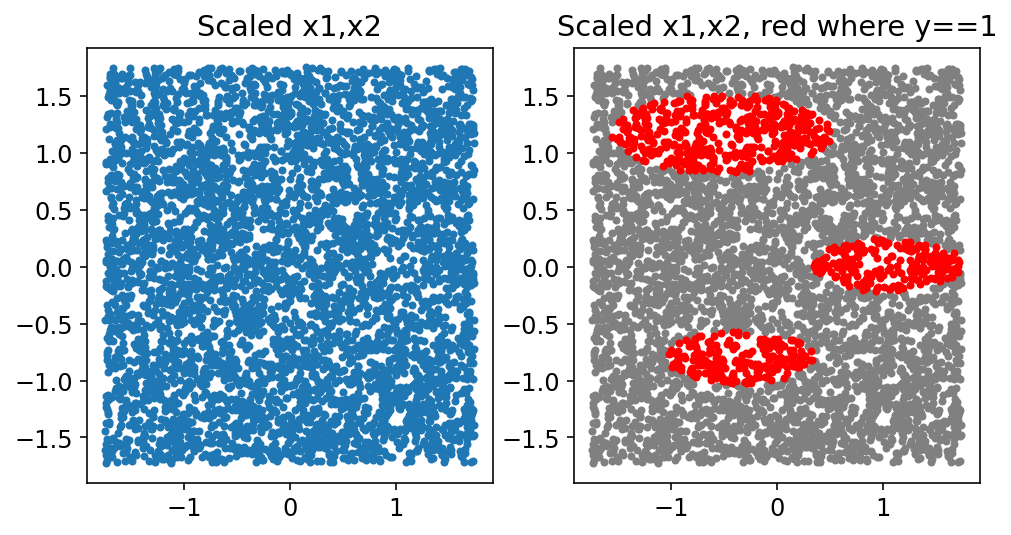

In [12]:
# lets normalize the values of features
data = np.array(list(zip(x1,x2)))
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
x1 = data_scaled[:,0]
x2 = data_scaled[:,1]
x1 = x1.round(3)
x2 = x2.round(3)

plt.rcParams["figure.figsize"] = (8, 4) # (width, height)
fig,(ax1,ax2) = plt.subplots(1,2)
_ = ax1.scatter(x1,x2, marker='.')
_ = ax1.set_title("Scaled x1,x2")
indices = y == 1
_ = ax2.scatter(x1[~indices], x2[~indices], c = "grey", marker='.')
_ = ax2.scatter(x1[indices], x2[indices], c = 'red', marker='.')
_ = ax2.set_title("Scaled x1,x2, red where y==1")
plt.show()

In [13]:
%%time
# -------------------------------------- 
# Logistic Regression - 130 ms for 10K points
global model_lr, model_rf, model_xg
model_lr = LogisticRegression(class_weight="balanced", solver='lbfgs', C=10)
print("model_name =",model_lr.__class__.__name__)
model_lr.fit(data, y) 
# --------------------------------------
# RandomForest - 256 ms for 10K points
model_rf = RandomForestClassifier(n_estimators=100) 
print("model_name =",model_rf.__class__.__name__)
model_rf.fit(data, y) 
# --------------------------------------
# XGBoost - 270 ms for 10K points
os.environ['KMP_DUPLICATE_LIB_OK']='True'
params = { 'eta'        : 0.03,
           'objective'  : 'binary:logistic',
           'eval_metric': 'auc',
           'max_depth'  : 15,
           'use_label_encoder' : False
         }
params['eta'] = 0.03
model_xg = XGBClassifier(**params) 
print("model_name =",model_xg.__class__.__name__)
model_xg.fit(data, y) 
# --------------------------------------
# model = MultinomialNB() # needs non-negative numbers
# --------------------------------------
# Linear Support Vector Classification
# model = LinearSVC(max_iter=10000) # doesn't converge
# model = sklearn.svm.NuSVR(gamma='auto') 
# 72 sec for 10K points - really slow
# --------------------------------------
print("DONE")

model_name = LogisticRegression
model_name = RandomForestClassifier
model_name = XGBClassifier
DONE
CPU times: user 3.66 s, sys: 1.13 s, total: 4.79 s
Wall time: 1.42 s


In [14]:
predictions = {}
predictions['Actual'] = y
for model in [model_lr,model_rf,model_xg]:
    label = model.__class__.__name__
    print(label)
    yp = model.predict(data)   # predicted on training data
    predictions[label] = yp
    yp = np.array([round(x) for x in yp])
    expected  = y 
    predicted = yp
    print(y[:10])
    print(yp[:10])
    confusion = metrics.confusion_matrix(expected, predicted)
    print(confusion)
    print("-"*40)

LogisticRegression
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1 1 0 1 0 1 0 0 0 1]
[[2265 1840]
 [ 445  450]]
----------------------------------------
RandomForestClassifier
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0 0 0 0 0 0 0 0 0 1]
[[4105    0]
 [   0  895]]
----------------------------------------
XGBClassifier
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0 0 0 0 0 0 0 0 0 1]
[[4104    1]
 [   0  895]]
----------------------------------------


In [15]:
# plot_confusion_matrix(confusion, "")
# show_roc_curve(target=y, predict_proba=yp)

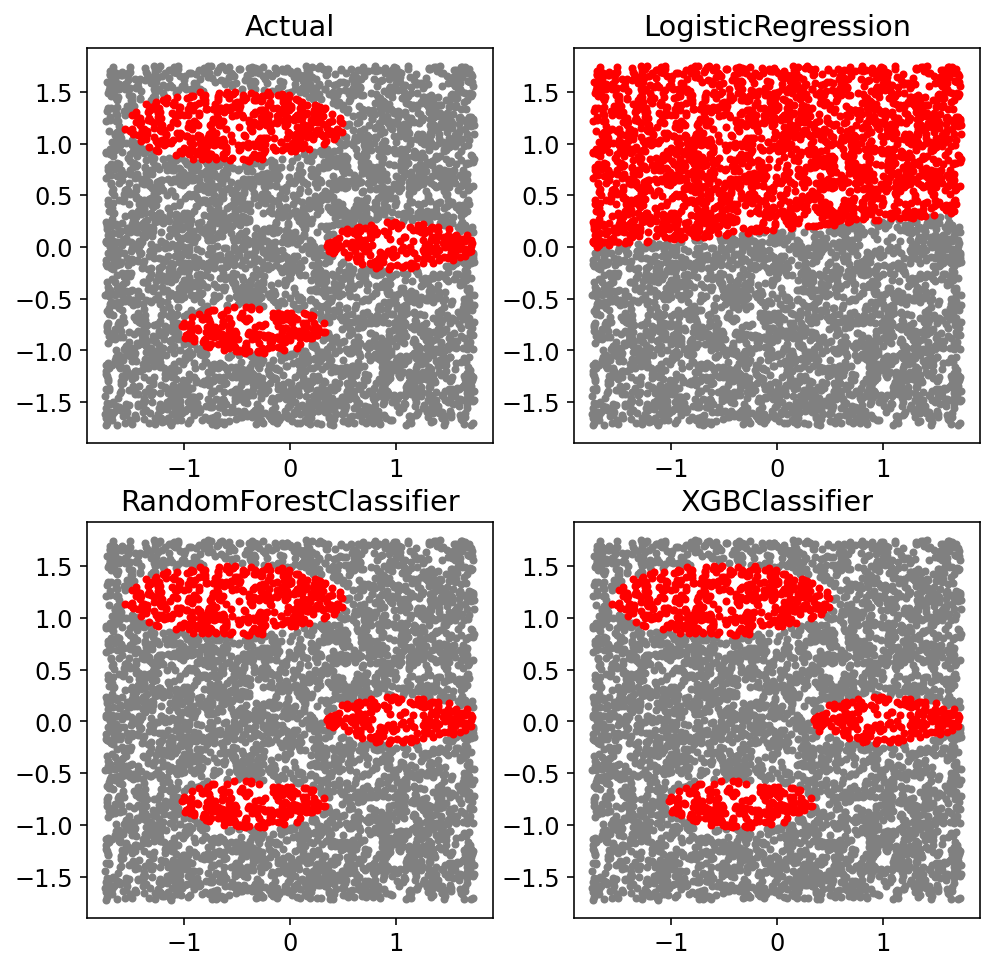

In [16]:
plt.rcParams["figure.figsize"] = (8, 8) # (width, height)
fig, ax = plt.subplots(2,2)
ax1,ax2,ax3,ax4 = ax.flatten()

labels = ['Actual','LogisticRegression','RandomForestClassifier','XGBClassifier']
axlist = [ax1,ax2,ax3,ax4]
for ii in range(len(axlist)):
    label = labels[ii]
    axx = axlist[ii]
    yy = predictions[label]
    ind_data = yy > 0.5
    _ = axx.scatter(x1[~ind_data], x2[~ind_data], c = "grey", marker='.')
    _ = axx.scatter(x1[ind_data], x2[ind_data], c = 'red', marker='.')
    _ = axx.set_title(label)

plt.show();

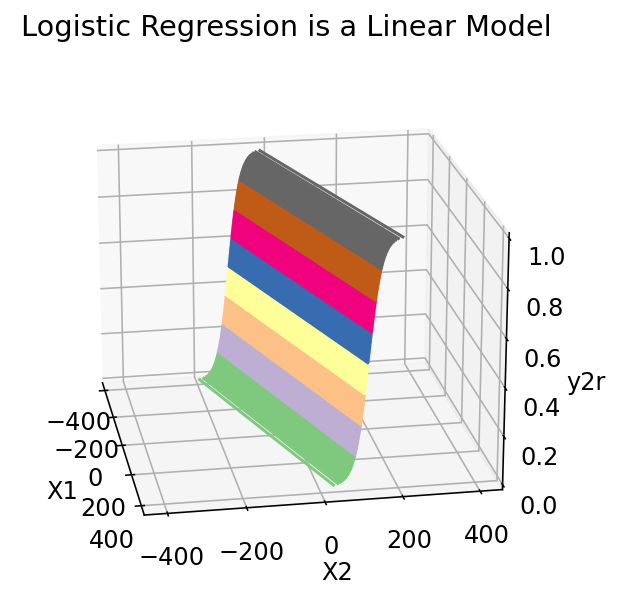

In [17]:
# Make a 3D graph for LogisticRegression
a1 = model_lr.coef_[0][0]
a2 = model_lr.coef_[0][1]
b = model_lr.intercept_[0]
x1r = np.linspace(-400, 400, 200, dtype=float) # [-2, ..., +2]
x2r = np.linspace(-400, 400, 200, dtype=float) # [-2, ..., +2]
y2r = np.zeros((200,200))
for i1 in range(200):
    for i2 in range(200):
        y2r[i1,i2] = sigmoid(b + a1*x1r[i1] + a2*x2r[i2])
# plot
_X1, _X2 = np.meshgrid(x1r, x2r, indexing='ij')

plt.rcParams["figure.figsize"] = (5, 5) # (width, height)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(_X1, _X2, y2r, 200, cmap=cm.Accent)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('y2r');
ax.view_init(elev=20, azim=-10)

_ = ax.set_title("Logistic Regression is a Linear Model")
plt.show();

In [18]:
# find which columns' values change their distribution the most
# when we change from rows with y=0 to y==1.
# To compare two distributions we will use Kolmogorov-Smirnov test.
#  - https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
# Note - this is just one of many tests, for example, read this discussion:
#  - https://stats.stackexchange.com/questions/1001/is-spearmans-correlation-coefficient-usable-to-compare-distributions
# 
# function ks_2samp(array1, array2) 
# compares distributions of values in two arrays
# and returns p_value
#    p_value > 0.4 - distributions are very similar (identical)
#    p_value very small - distributions differ

In [19]:
print("small p_values indicate different distributions")
print('-'*40)
print("label => p_value") 
print('-'*40)

df = pd.DataFrame({'x1':data[:,0],'x2':data[:,1],'Class':y})
df_ks = top_corollaries(df)
display(df_ks.head(10))

small p_values indicate different distributions
----------------------------------------
label => p_value
----------------------------------------
x1 => 0.163620
x2 => 0.303281


,col,p_val
1,x2,0.303281
0,x1,0.163620


<h3>Create Cross-Validation Folds</h3>
<p>We randomly split all data rows in 4 groups (folds) numbered as 0,1,2,3
<br>For modeling we will randomly select one of the folds as test data, 
<br>and combination of other three folds as training data.
<br>Thus we can repeat modeling 4 times (if there are 4 folds).
<br>Below we do that. We also repeat everything 3 times.
<br>So we make 12 calculations, and then calculate mean and standard deviation.</p>

In [20]:
# df is a dataframe with columns [x1,x2,Class]
n_cv = 4           # number of cross-validation folds
df_len = len(df)   # length of data

# add column "cv_fold" and randomly populate it with numbers 0,1,2,3
df['cv_fold'] = np.random.randint(0,4, df_len)  
print("values in column 'cv_fold':", np.unique(df['cv_fold']))

print("check that classes (0 or 1) are approx evenly distributed")
print("between folds: (0+1+2+3)/4 = 1.5")
print ("0 => %.4f" % np.mean(df.cv_fold[df.Class == 0]))
print ("1 => %.4f" % np.mean(df.cv_fold[df.Class == 1]))

values in column 'cv_fold': [0 1 2 3]
check that classes (0 or 1) are approx evenly distributed
between folds: (0+1+2+3)/4 = 1.5
0 => 1.5252
1 => 1.4760


running  Logistic_Regression
(rep=0, fold=0), precision=0.202, recall=0.485, f1score=0.285, 0.01secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=0, fold=1), precision=0.231, recall=0.597, f1score=0.333, 0.01secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=0, fold=2), precision=0.196, recall=0.521, f1score=0.285, 0.01secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=0, fold=3), precision=0.213, recall=0.466, f1score=0.292, 0.01secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=1, fold=0), precision=0.202, recall=0.485, f1score=0.285, 0.01secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=1, fol

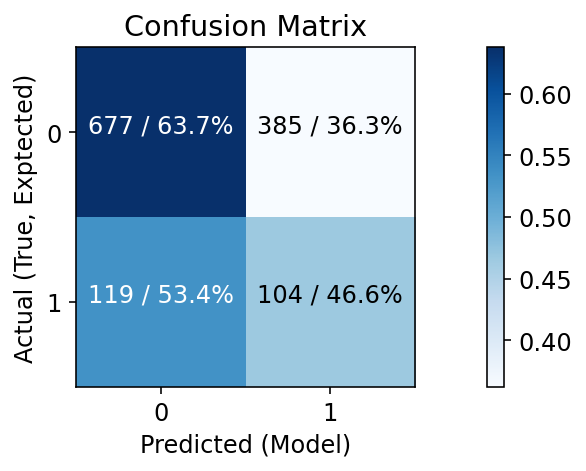

Elapsed 0.23 sec
----------------------------------------------------------------- 

running  RF_baseline
(rep=0, fold=0), precision=0.968, recall=0.914, f1score=0.940, 0.21secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=0, fold=1), precision=0.940, recall=0.973, f1score=0.957, 0.21secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=0, fold=2), precision=0.990, recall=0.906, f1score=0.946, 0.21secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=0, fold=3), precision=0.944, recall=0.910, f1score=0.927, 0.21secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=1, fold=0), precision=0.959, recall=0.910, f1score=0.934, 0.21secconfusion matrix <module 'sklearn' from '/Users/levselec

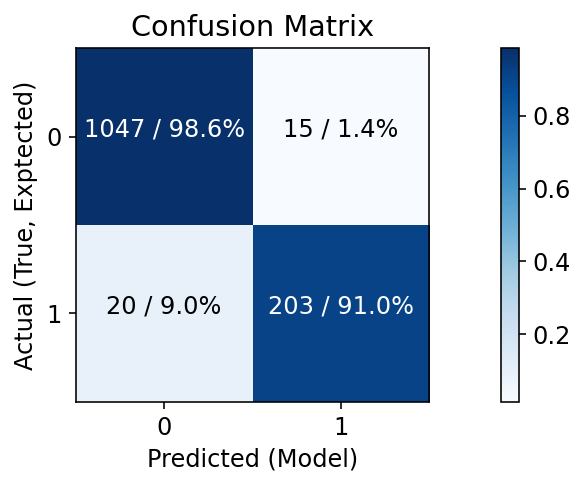

Elapsed 2.58 sec
----------------------------------------------------------------- 

running  XGBoost
(rep=0, fold=0), precision=0.957, recall=0.948, f1score=0.953, 1.03secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=0, fold=1), precision=0.982, recall=0.987, f1score=0.985, 1.04secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=0, fold=2), precision=0.972, recall=0.972, f1score=0.972, 0.92secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=0, fold=3), precision=0.922, recall=0.951, f1score=0.936, 0.62secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=1, fold=0), precision=0.957, recall=0.948, f1score=0.953, 1.11secconfusion matrix <module 'sklearn' from '/Users/levselector/

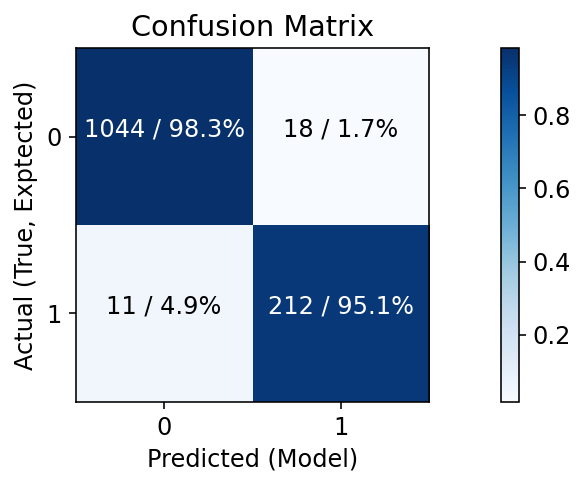

Elapsed 9.66 sec
----------------------------------------------------------------- 

DONE
CPU times: user 36.8 s, sys: 8.36 s, total: 45.1 s
Wall time: 12.5 s


In [21]:
%%time
# dict for results
results = {}
cols = sorted(set(list(df.columns)) - set(['Class']))

# ------------------------------------------------
# Logistic Regression
model_lr = LogisticRegression(class_weight="balanced", solver='lbfgs', C=10)
label = 'Logistic_Regression'
results[label] = run_cv(df, model_lr, label, cols, repeat = 3)

# ------------------------------------------------
# Random Forest
model_rf = RandomForestClassifier(n_estimators=100)
label = 'RF_baseline'
results[label] = run_cv(df, model_rf, label, cols, repeat = 3)

# ------------------------------------------------
# XGBoost
os.environ['KMP_DUPLICATE_LIB_OK']='True'
params = { 'eta'        : 0.03,
           'objective'  : 'binary:logistic',
           'eval_metric': 'auc',
           'max_depth'  : 15,
           'use_label_encoder' : False}
params['eta'] = 0.03
model_xgb = XGBClassifier(**params)
label = 'XGBoost'
results[label] = run_cv(df, model_xgb, label, cols, repeat = 3)
print("DONE")

In [22]:
results_orig = results.copy()
# round the results to 3 decimals
for k1 in results.keys():
    for k2 in results[k1].keys():
        (v1,v2) = results[k1][k2]
        v1 = round(v1,3)
        v2 = round(v2,3)
        results[k1][k2] = (v1,v2)
df_result = pd.DataFrame.from_dict(results)
# print results as tuples (value, std), where std = Standard Deviation
# for example (0.5, 0.1) means: 0.5 +/- 0.1
df_result.transpose()

,precision,recall,f1score,seconds
Logistic_Regression,"(0.21, 0.013)","(0.517, 0.05)","(0.299, 0.02)","(0.011, 0.001)"
RF_baseline,"(0.955, 0.023)","(0.925, 0.027)","(0.939, 0.012)","(0.207, 0.002)"
XGBoost,"(0.958, 0.023)","(0.964, 0.016)","(0.961, 0.018)","(0.797, 0.201)"


## Categorical data 

,A,B,C,Class,st__0,st__1,st__2,st__3,st__4,st__5,...,st__390,st__391,st__392,st__393,st__394,st__395,st__396,st__397,st__398,st__399
0,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


0    9918
1      82
Name: Class, dtype: int64

model_name = LogisticRegression
running  LogisticRegression
(rep=0, fold=0), precision=0.737, recall=0.875, f1score=0.800, 0.25secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=0, fold=1), precision=0.221, recall=0.944, f1score=0.358, 0.17secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=0, fold=2), precision=0.333, recall=0.870, f1score=0.482, 0.28secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=0, fold=3), precision=0.323, recall=0.840, f1score=0.467, 0.21secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>


finished 4 calculations
Precision : 0.403508 +- 0.197418
Recall    : 0.882252 +- 0.038297
F1 score  : 0.526622 +- 0.164922
Seconds   : 0.227450 +- 0.039389
[[2419   44]
 [

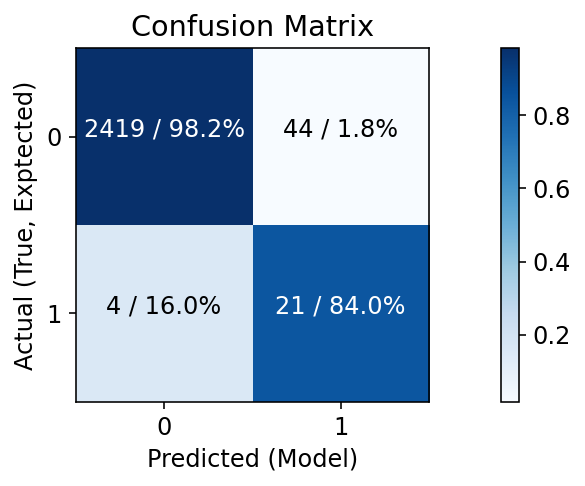

Elapsed 1.01 sec
----------------------------------------------------------------- 

model_name = RandomForestClassifier
running  RandomForestClassifier
(rep=0, fold=0), precision=1.000, recall=0.875, f1score=0.933, 1.92secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=0, fold=1), precision=0.850, recall=0.944, f1score=0.895, 1.91secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=0, fold=2), precision=1.000, recall=0.870, f1score=0.930, 1.91secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=0, fold=3), precision=0.955, recall=0.840, f1score=0.894, 1.88secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>


finished 4 calculations
Precision : 0.951136 +- 0.061269
Recall    : 0.882252 

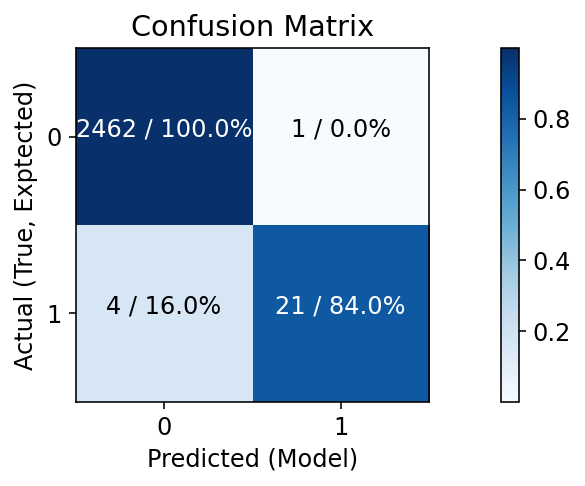

Elapsed 7.72 sec
----------------------------------------------------------------- 

model_name = XGBClassifier
running  XGBClassifier
(rep=0, fold=0), precision=1.000, recall=0.875, f1score=0.933, 2.62secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=0, fold=1), precision=0.850, recall=0.944, f1score=0.895, 2.59secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=0, fold=2), precision=1.000, recall=0.870, f1score=0.930, 2.31secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>

(rep=0, fold=3), precision=0.955, recall=0.840, f1score=0.894, 2.12secconfusion matrix <module 'sklearn' from '/Users/levselector/miniconda3/lib/python3.9/site-packages/sklearn/__init__.py'>


finished 4 calculations
Precision : 0.951136 +- 0.061269
Recall    : 0.882252 +- 0.038297
F1 sco

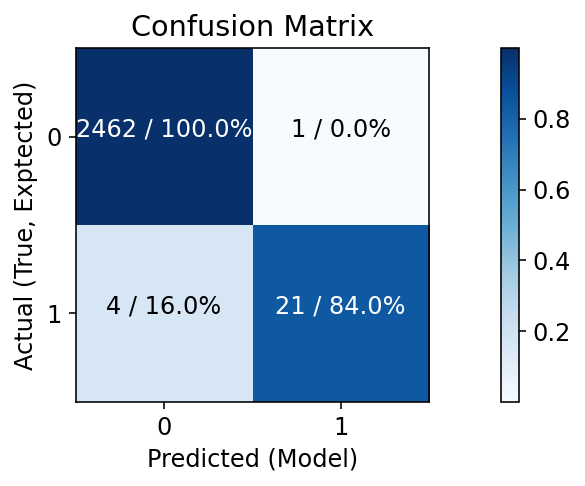

Elapsed 9.74 sec
----------------------------------------------------------------- 

DONE


,precision,recall,f1score,seconds
LogisticRegression,"(0.404, 0.197)","(0.882, 0.038)","(0.527, 0.165)","(0.227, 0.039)"
RandomForestClassifier,"(0.951, 0.061)","(0.882, 0.038)","(0.913, 0.019)","(1.906, 0.013)"
XGBClassifier,"(0.951, 0.061)","(0.882, 0.038)","(0.913, 0.019)","(2.41, 0.21)"


CPU times: user 1min 38s, sys: 5.89 s, total: 1min 44s
Wall time: 18.5 s


[('lg', LogisticRegression(C=10, class_weight='balanced')),
 ('rf', RandomForestClassifier(n_estimators=200)),
 ('xgb',
  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
                early_stopping_rounds=None, enable_categorical=False, eta=0.03,
                eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
                importance_type=None, interaction_constraints='',
                learning_rate=0.0299999993, max_bin=256, max_cat_to_onehot=4,
                max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
                missing=nan, monotone_constraints='()', n_estimators=100,
                n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
                reg_alpha=0, ...))]

In [23]:
%%time
# let's run model with added categorical data
N=10000
ar0 = np.zeros(N)
ar_class = ar0
# ar_class = np.random.choice([0, 1], size=(N,), p=[.98, .02])
ar1      = np.random.choice(list(range(400)), size=(N,))
df = pd.DataFrame({'A':ar0,'B':ar0,'C':ar0,'D':ar1,'Class':ar_class})
mask = df.D.isin([20,30,40])
df.loc[mask,'Class'] = 1

# Now add some noise

n1 = np.random.choice([0, 2], size=(N,), p=[.999, 0.001])
n2 = np.random.choice([0, -2], size=(N,), p=[.9, 0.1])
vals = df.Class.values + n1 + n2
vals = np.where(vals > 0.5, 1, 0)
df['Class'] = vals

df2 = pd.get_dummies(df['D'], prefix="st_")
df = pd.concat([df,df2],axis=1)
df.drop(['D'],axis=1, inplace=True)
display(df.head())
display(df.Class.value_counts())
run_stuff(df, models=['lg','rf','xgb'])

In [24]:
nb_time_end = time.time()
print_date_time(label = "date_time")
print("Total run time = %.2f sec" % (nb_time_end-nb_time_start))

date_time  :  2022-07-23 15:07:35
Total run time = 34.25 sec
